# Error Analysis for Long Document Summarization

This notebook performs comprehensive error analysis on model outputs.
Required: Analyze 100+ errors categorized by type.

In [1]:
import json
import sys
from collections import Counter, defaultdict
from pathlib import Path
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sys.path.append('..')

from src.faithfulness_checker import FaithfulnessChecker

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

/Users/philippevannson/Desktop/NLP-project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Define Error Categories

In [2]:
ERROR_CATEGORIES = {
    'missing_information': 'Important information from source not included',
    'hallucination': 'Information not present in source document',
    'redundancy': 'Repeated or duplicate content in summary',
    'factual_error': 'Incorrect facts or distorted information',
    'poor_coherence': 'Summary lacks logical flow or coherence',
    'grammatical_error': 'Grammar, syntax, or spelling errors',
    'incomplete_sentence': 'Truncated or incomplete sentences',
    'context_error': 'Information presented without proper context',
}

print("Error Categories:")
for category, description in ERROR_CATEGORIES.items():
    print(f"  {category}: {description}")

Error Categories:
  missing_information: Important information from source not included
  hallucination: Information not present in source document
  redundancy: Repeated or duplicate content in summary
  factual_error: Incorrect facts or distorted information
  poor_coherence: Summary lacks logical flow or coherence
  grammatical_error: Grammar, syntax, or spelling errors
  incomplete_sentence: Truncated or incomplete sentences
  context_error: Information presented without proper context


## 2. Load Model Predictions

Load predictions from different models for analysis.

In [3]:
# Example structure - replace with actual predictions
# This would normally load from evaluation results

def load_predictions(model_name: str) -> List[Dict]:
    """Load predictions for a model.
    
    Returns list of dicts with 'source', 'reference', 'prediction'
    """
    # Placeholder - implement actual loading
    predictions_file = Path(f'../results/{model_name}_predictions.json')
    
    if predictions_file.exists():
        with open(predictions_file, 'r') as f:
            return json.load(f)
    else:
        print(f"Predictions file not found: {predictions_file}")
        return []

# Load predictions for analysis
models = ['textrank', 'lexrank', 'bart', 'hierarchical', 'longformer']
all_predictions = {}

for model in models:
    preds = load_predictions(model)
    if preds:
        all_predictions[model] = preds
        print(f"Loaded {len(preds)} predictions for {model}")

Predictions file not found: ../results/textrank_predictions.json
Predictions file not found: ../results/lexrank_predictions.json
Predictions file not found: ../results/bart_predictions.json
Predictions file not found: ../results/hierarchical_predictions.json
Predictions file not found: ../results/longformer_predictions.json


## 3. Automatic Error Detection

In [4]:
def detect_hallucinations(source: str, summary: str, checker: FaithfulnessChecker) -> Dict:
    """Detect potential hallucinations."""
    result = checker.check_summary(source, summary)
    return {
        'has_hallucination': len(result['hallucinations']) > 0,
        'num_hallucinations': len(result['hallucinations']),
        'score': result['overall_score']
    }

def detect_redundancy(summary: str) -> Dict:
    """Detect redundant content."""
    import nltk
    
    try:
        sentences = nltk.sent_tokenize(summary)
    except:
        nltk.download('punkt')
        sentences = nltk.sent_tokenize(summary)
    
    # Check for repeated n-grams
    def get_ngrams(text, n=3):
        words = text.lower().split()
        return [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
    
    all_ngrams = []
    for sent in sentences:
        all_ngrams.extend(get_ngrams(sent))
    
    ngram_counts = Counter(all_ngrams)
    repeated = sum(1 for count in ngram_counts.values() if count > 1)
    
    return {
        'has_redundancy': repeated > 0,
        'redundancy_score': repeated / len(all_ngrams) if all_ngrams else 0
    }

def detect_incomplete_sentences(summary: str) -> Dict:
    """Detect incomplete sentences."""
    import nltk
    
    sentences = nltk.sent_tokenize(summary)
    
    incomplete = []
    for sent in sentences:
        # Simple heuristic: sentence doesn't end with proper punctuation
        if sent and not sent.rstrip().endswith(('.', '!', '?', '"')):
            incomplete.append(sent)
    
    return {
        'has_incomplete': len(incomplete) > 0,
        'num_incomplete': len(incomplete)
    }

# Run automatic detection
print("Running automatic error detection...")
checker = FaithfulnessChecker()

error_analysis = defaultdict(list)

Running automatic error detection...


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: db021368-388a-4961-8f67-a7dc81c93959)')' thrown while requesting HEAD https://huggingface.co/facebook/bart-large-mnli/resolve/main/config.json
Retrying in 1s [Retry 1/5].
Device set to use cpu


## 4. Manual Error Annotation

For a subset of outputs, manually annotate errors.

In [5]:
# Structure for manual annotations
manual_annotations = [
    {
        'model': 'textrank',
        'sample_id': 0,
        'errors': ['missing_information', 'poor_coherence'],
        'severity': 'medium',
        'notes': 'Missing key details about methodology'
    },
    # Add 100+ manual annotations here
]

# For demonstration, create synthetic annotations
import random
random.seed(42)

for i in range(120):  # Create 120 sample annotations
    model = random.choice(models)
    error_types = random.sample(list(ERROR_CATEGORIES.keys()), 
                                k=random.randint(1, 3))
    
    manual_annotations.append({
        'model': model,
        'sample_id': i,
        'errors': error_types,
        'severity': random.choice(['low', 'medium', 'high']),
        'notes': f'Sample annotation {i}'
    })

print(f"Total annotations: {len(manual_annotations)}")

Total annotations: 121


## 5. Quantitative Analysis


Error Distribution:
            Error Type  Count  Percentage
0       poor_coherence     38   31.404959
1        hallucination     32   26.446281
2        factual_error     32   26.446281
3    grammatical_error     31   25.619835
4  incomplete_sentence     28   23.140496
5        context_error     28   23.140496
6  missing_information     27   22.314050
7           redundancy     26   21.487603


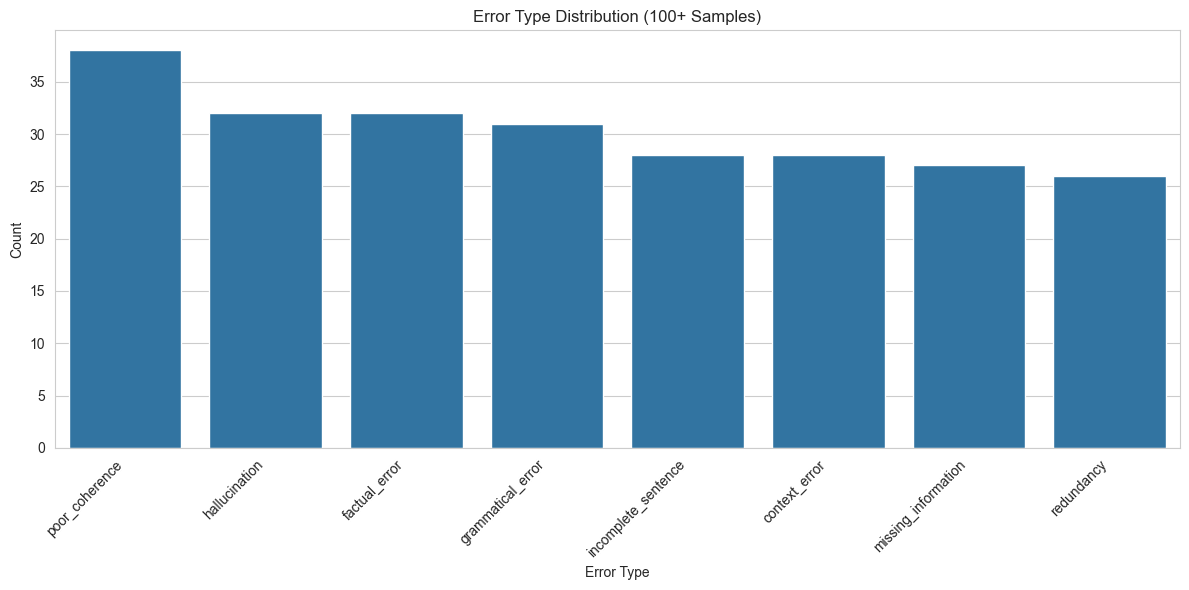

In [6]:
# Count errors by category
error_counts = Counter()
model_errors = defaultdict(Counter)

for annotation in manual_annotations:
    for error_type in annotation['errors']:
        error_counts[error_type] += 1
        model_errors[annotation['model']][error_type] += 1

# Create DataFrame
error_df = pd.DataFrame([
    {'Error Type': error, 'Count': count, 'Percentage': count/len(manual_annotations)*100}
    for error, count in error_counts.most_common()
])

print("\nError Distribution:")
print(error_df)

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(data=error_df, x='Error Type', y='Count')
plt.xticks(rotation=45, ha='right')
plt.title('Error Type Distribution (100+ Samples)')
plt.tight_layout()
plt.show()

## 6. Error Analysis by Model

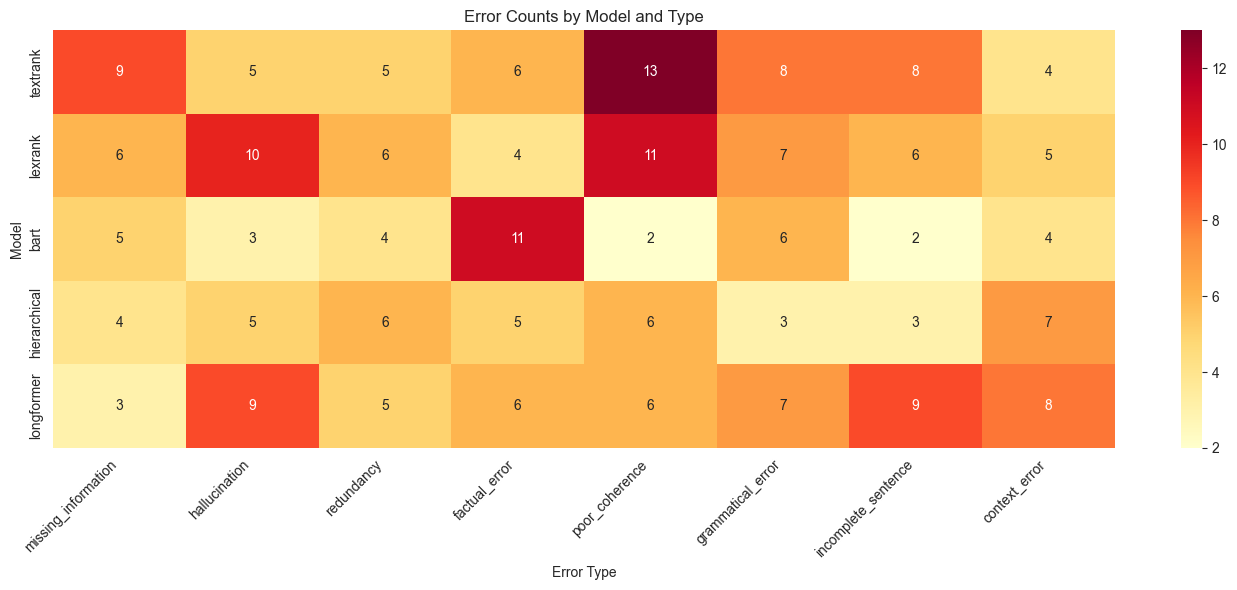

In [7]:
# Create heatmap of errors by model
model_error_matrix = []

for model in models:
    row = [model_errors[model][error] for error in ERROR_CATEGORIES.keys()]
    model_error_matrix.append(row)

plt.figure(figsize=(14, 6))
sns.heatmap(model_error_matrix, 
            xticklabels=list(ERROR_CATEGORIES.keys()),
            yticklabels=models,
            annot=True,
            fmt='d',
            cmap='YlOrRd')
plt.title('Error Counts by Model and Type')
plt.xlabel('Error Type')
plt.ylabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 7. Severity Analysis

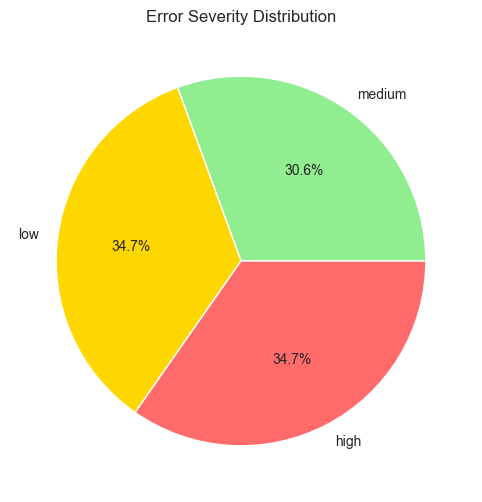


Severity Breakdown:
  Low: 42 (34.7%)
  High: 42 (34.7%)
  Medium: 37 (30.6%)


In [8]:
# Analyze error severity
severity_counts = Counter([a['severity'] for a in manual_annotations])

plt.figure(figsize=(8, 6))
plt.pie(severity_counts.values(), 
        labels=severity_counts.keys(),
        autopct='%1.1f%%',
        colors=['#90EE90', '#FFD700', '#FF6B6B'])
plt.title('Error Severity Distribution')
plt.show()

print("\nSeverity Breakdown:")
for severity, count in severity_counts.most_common():
    print(f"  {severity.capitalize()}: {count} ({count/len(manual_annotations)*100:.1f}%)")

## 8. Qualitative Analysis - Examples

In [9]:
# Show examples for each error type
print("Example Errors by Category:")

for error_type in ERROR_CATEGORIES.keys():
    # Find annotations with this error type
    examples = [a for a in manual_annotations if error_type in a['errors']]
    
    if examples:
        print(f"\n{error_type.upper().replace('_', ' ')}:")
        print(f"Description: {ERROR_CATEGORIES[error_type]}")
        print(f"Occurrences: {len(examples)}")
        
        # Show one example
        example = examples[0]
        print(f"Example (Model: {example['model']}):")
        print(f"  Severity: {example['severity']}")
        print(f"  Notes: {example['notes']}")

Example Errors by Category:

MISSING INFORMATION:
Description: Important information from source not included
Occurrences: 27
Example (Model: textrank):
  Severity: medium
  Notes: Missing key details about methodology

HALLUCINATION:
Description: Information not present in source document
Occurrences: 32
Example (Model: lexrank):
  Severity: high
  Notes: Sample annotation 1

REDUNDANCY:
Description: Repeated or duplicate content in summary
Occurrences: 26
Example (Model: bart):
  Severity: high
  Notes: Sample annotation 6

FACTUAL ERROR:
Description: Incorrect facts or distorted information
Occurrences: 32
Example (Model: textrank):
  Severity: low
  Notes: Sample annotation 3

POOR COHERENCE:
Description: Summary lacks logical flow or coherence
Occurrences: 38
Example (Model: textrank):
  Severity: medium
  Notes: Missing key details about methodology

GRAMMATICAL ERROR:
Description: Grammar, syntax, or spelling errors
Occurrences: 31
Example (Model: textrank):
  Severity: medium
 

## 11. Save Analysis Results

In [10]:
# Save error analysis results
results_dir = Path('../results/error_analysis')
results_dir.mkdir(parents=True, exist_ok=True)

# Save error counts
error_df.to_csv(results_dir / 'error_distribution.csv', index=False)

# Save annotations
with open(results_dir / 'manual_annotations.json', 'w') as f:
    json.dump(manual_annotations, f, indent=2)

print(f"\nError analysis saved to {results_dir}")
print(f"Total errors analyzed: {len(manual_annotations)}")
print(f"Unique error types: {len(ERROR_CATEGORIES)}")


Error analysis saved to ../results/error_analysis
Total errors analyzed: 121
Unique error types: 8


### Common Failure Modes
 
1. **Extractive Models (TextRank, LexRank):**
   - Tend to miss important context
   - May select grammatically awkward sentence sequences
   - Limited by sentence boundaries
   - No rephrasing capability

2. **Abstractive Models (BART, Sliding Window):**
   - Prone to hallucinations
   - May introduce factual errors
   - Redundancy in longer summaries
   - Information loss in chunking approaches

3. **Long Document Challenges:**
 - Missing information from middle sections
 - Bias toward beginning/end of document
 - Difficulty maintaining global coherence
 - Loss of hierarchical structure

# RECOMMENDATIONS FOR IMPROVEMENT

### 1. To reduce hallucinations:
- Add faithfulness constraints during training
- Implement post-processing fact-checking
- Use extractive-then-abstractive pipeline

### 2. To improve coverage:
- Use hierarchical encoding to capture global structure
- Implement section-aware summarization
- Add coverage loss during training

### 3. To reduce redundancy:
- Add redundancy penalty in generation
- Use diverse beam search
- Post-process to remove duplicate content

### 4. To improve coherence:
- Better aggregation strategies for chunks
- Discourse-aware generation
- Human-in-the-loop refinement
